# Sewer Line Rapid Assesment Tool Project




## Introduction

This notebook reflects the evaluation of Classifiers for predicting Sl-RAT Scores and the target variable in this notebook calculated at the end of the SL_RAT_EDA-new data notebook. 


## Imports


In [116]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

In [117]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from sklearn.model_selection import train_test_split

In [118]:
def show_scores(test, pred, show=True):
    accuracy = accuracy_score(test, pred)
    precision = precision_score(test, pred)
    recall = recall_score(test, pred)
    f1 = f1_score(test, pred)
    
    if show:
        print('Accuracy:', accuracy )
        print('Precision:', precision )
        print('Recall:', recall)    
        print('F1 score:', f1) 
    
    return accuracy, precision, recall, f1

## Get the Data

We'll work with the SL_RAT_EDA2 csv file from Baltimore County. It has pipe type, pipe lining type, pipe size, pipe material, pipe slope, connection length, installation date, and calculated target column from SL-RAT EDA2 Notebook. 




In [119]:
df = pd.read_csv('SL_RAT_EDA2.csv', index_col=0)

In [120]:
df.head()

,TYPE,LINING_TYP,PIPE_SIZE,PIPE_MATER,SLOPE,LENGTH,UPSTREAM_I,DOWNSTREAM,time_since_install_da,target
0,COLLECTOR,NONE,12.0,VITRIFIED CLAY PIPE,0.49,400.69,464.26,462.33,35192.0,1
1,COLLECTOR,NONE,8.0,VITRIFIED CLAY PIPE,2.50,374.65,478.42,469.26,35192.0,1
2,COLLECTOR,NONE,8.0,VITRIFIED CLAY PIPE,2.00,385.08,384.65,376.80,35192.0,1
3,COLLECTOR,NONE,8.0,VITRIFIED CLAY PIPE,2.00,301.28,390.86,384.75,35192.0,1
4,COLLECTOR,NONE,15.0,VITRIFIED CLAY PIPE,0.30,302.96,9.68,8.81,26426.0,0


### Checking Distributions and Data Issues 

In [121]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1171 entries, 0 to 1170
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   TYPE                   1171 non-null   object 
 1   LINING_TYP             1171 non-null   object 
 2   PIPE_SIZE              1171 non-null   float64
 3   PIPE_MATER             1171 non-null   object 
 4   SLOPE                  1171 non-null   float64
 5   LENGTH                 1171 non-null   float64
 6   UPSTREAM_I             1171 non-null   float64
 7   DOWNSTREAM             1171 non-null   float64
 8   time_since_install_da  1171 non-null   float64
 9   target                 1171 non-null   int64  
dtypes: float64(6), int64(1), object(3)
memory usage: 100.6+ KB


> Our data consist of three categorical and five numerical columns with no missing values.
Now it is ready for training!




In [164]:
df.isna().sum()

TYPE                     0
LINING_TYP               0
PIPE_SIZE                0
PIPE_MATER               0
SLOPE                    0
LENGTH                   0
UPSTREAM_I               0
DOWNSTREAM               0
time_since_install_da    0
target                   0
dtype: int64

No missing values. 

In [162]:
df.target.value_counts().sort_index()

0    379
1    792
Name: target, dtype: int64

Imbalanced target variable

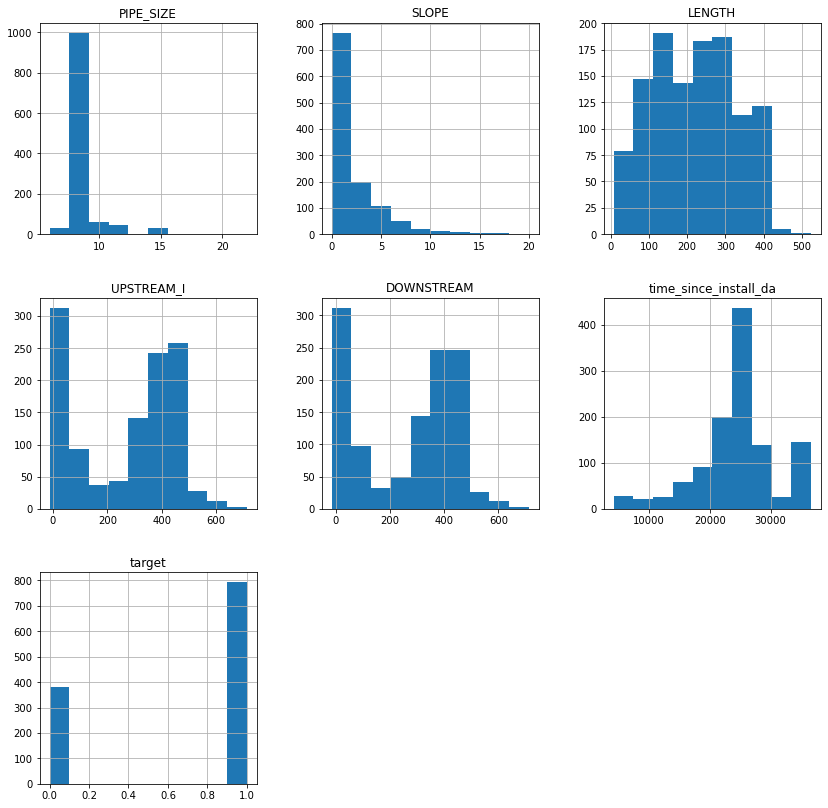

In [160]:
import matplotlib.pyplot as plt
%matplotlib inline

df.hist(figsize=(14,14))
plt.show()

## Train Test Split


In [123]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
print(f'Training examples: {X_train.shape[0]:,}')
print(f'Test examples: {X_test.shape[0]:,}')

Training examples: 936
Test examples: 235


<AxesSubplot:>

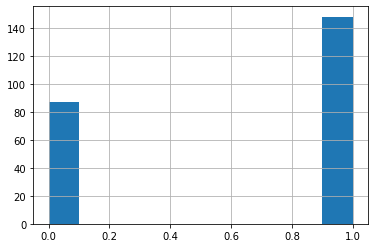

In [124]:
y_test.hist()

In [125]:
X_train.head()

,TYPE,LINING_TYP,PIPE_SIZE,PIPE_MATER,SLOPE,LENGTH,UPSTREAM_I,DOWNSTREAM,time_since_install_da
1040,COLLECTOR,NONE,8.0,VITRIFIED CLAY PIPE,3.20,236.79,82.95,75.38,27157.0
1109,COLLECTOR,UNKNOWN,8.0,VITRIFIED CLAY PIPE,3.20,397.68,406.55,394.35,26791.0
880,COLLECTOR,NONE,8.0,VITRIFIED CLAY PIPE,3.00,99.44,357.43,354.58,28252.0
772,COLLECTOR,NONE,8.0,CAST IRON,0.40,80.21,-3.82,-4.15,17295.0
97,COLLECTOR,NONE,15.0,VITRIFIED CLAY PIPE,0.92,154.30,245.83,244.30,25696.0


#### Creating a pipeline to preprocess the data and fit the model.


In [131]:
categorical_features = [
    'TYPE',
    'LINING_TYP',
    'PIPE_MATER'
]

numerical_features = [
    'PIPE_SIZE',
    'SLOPE',
    'UPSTREAM_I',
    'DOWNSTREAM',
    'LENGTH',
#     'time_since_install_da'
]

In [132]:
num_pipeline = Pipeline([
    ('impute_missing', SimpleImputer(strategy='median')),
    ('standardize_num', StandardScaler())
])

cat_pipeline = Pipeline([('impute_missing_cats', SimpleImputer(strategy='most_frequent')),
                          ('create_dummies_cats', OneHotEncoder(handle_unknown='ignore', drop='first'))]) 

# cat_val = cat_pipeline.fit_transform(X[categorical_features])
# cat_val

In [133]:
processing_pipeline = ColumnTransformer(transformers=[('proc_numeric', num_pipeline, numerical_features),
                                                      ('create_dummies', cat_pipeline, categorical_features)])

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC


rf = RandomForestClassifier(max_depth=3, class_weight='balanced')
modeling_pipeline = Pipeline([
    ('data_processing', processing_pipeline), 
#     ('model', DecisionTreeClassifier())
#     ('model', rf )
    ('model', LogisticRegression( class_weight='balanced'))
#     ('model', SVC( class_weight='balanced'))
]
)
modeling_pipeline.fit(X_train, y_train)

Pipeline(steps=[('data_processing',
                 ColumnTransformer(transformers=[('proc_numeric',
                                                  Pipeline(steps=[('impute_missing',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardize_num',
                                                                   StandardScaler())]),
                                                  ['PIPE_SIZE', 'SLOPE',
                                                   'UPSTREAM_I', 'DOWNSTREAM',
                                                   'LENGTH']),
                                                 ('create_dummies',
                                                  Pipeline(steps=[('impute_missing_cats',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                       

#### Evaluating the models on the test data


In [134]:
y_predictions = modeling_pipeline.predict(X_test)
y_predictions

array([1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1,
       0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1,
       0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1,
       0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0,
       0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0,
       0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1,
       1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1])

In [135]:
show_scores(y_test, y_predictions)

Accuracy: 0.5361702127659574
Precision: 0.6363636363636364
Recall: 0.6148648648648649
F1 score: 0.6254295532646049


(0.5361702127659574,
 0.6363636363636364,
 0.6148648648648649,
 0.6254295532646049)

I choose the F1 metric for modeling because of balance issues on the target variable. 

In [146]:
# https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html

from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.dummy import DummyClassifier
from sklearn.metrics import RocCurveDisplay

h = 0.02  # step size in the mesh

names = [
    "Dummy",
    "Nearest Neighbors",
    "Linear SVM",
    "RBF SVM",
    "Gaussian Process",
    "Decision Tree",
    "Random Forest",
    "Neural Net",
    "AdaBoost",
    "Naive Bayes",
    "QDA",
]



classifiers = [
    DummyClassifier(),
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025, class_weight='balanced'),
    SVC(gamma=2, C=1, class_weight='balanced'),
    GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(max_depth=5,  class_weight='balanced'),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1, class_weight='balanced'),
    MLPClassifier(alpha=1, max_iter=1000),
    AdaBoostClassifier( ),
    GaussianNB(),
    QuadraticDiscriminantAnalysis( ),
]


Dummy
Dummy  is predicting 1 class only


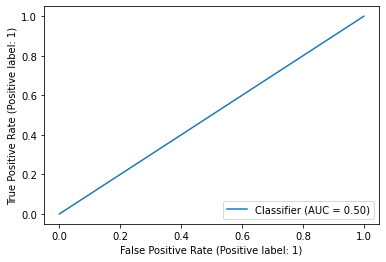

Nearest Neighbors


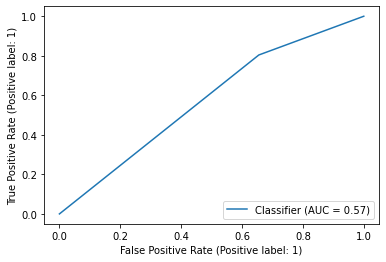

Linear SVM


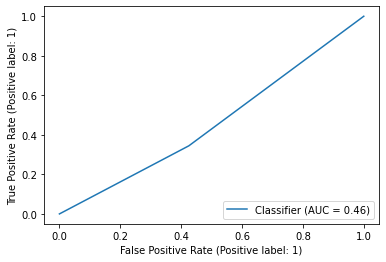

RBF SVM


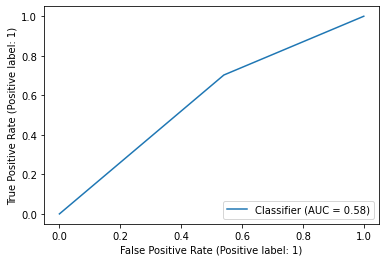

Gaussian Process


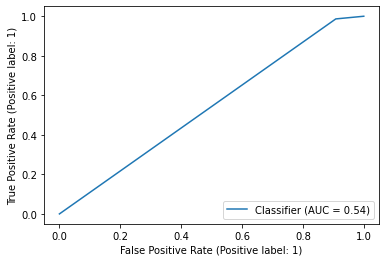

Decision Tree


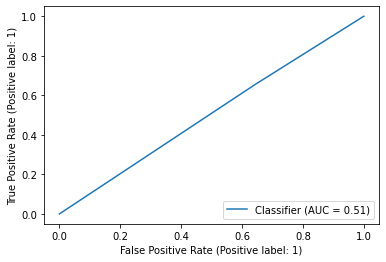

Random Forest


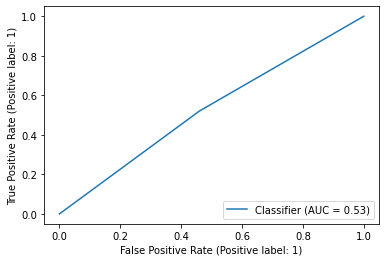

Neural Net


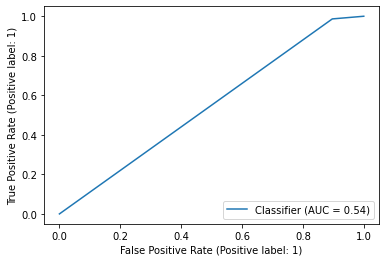

AdaBoost


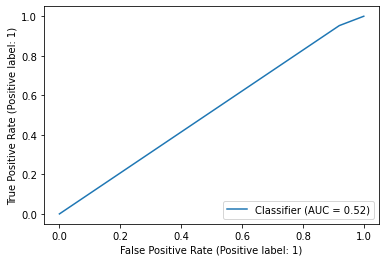

Naive Bayes


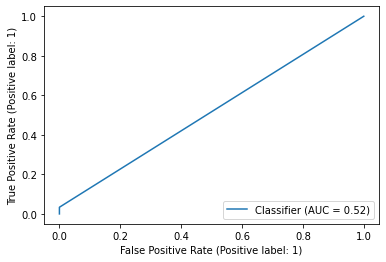

QDA


/Users/sophiasarica/opt/anaconda3/lib/python3.9/site-packages/sklearn/discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


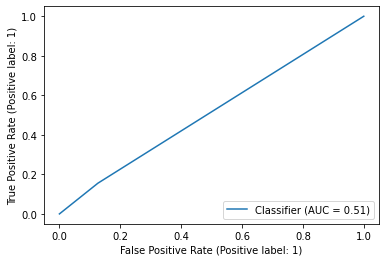

,classifier,accuracy,precision,recall,f1
7,Neural Net,0.659574,0.651786,0.986486,0.784946
4,Gaussian Process,0.655319,0.648889,0.986486,0.782842
0,Dummy,0.629787,0.629787,1.000000,0.772846
8,AdaBoost,0.629787,0.638009,0.952703,0.764228
1,Nearest Neighbors,0.634043,0.676136,0.804054,0.734568
3,RBF SVM,0.612766,0.688742,0.702703,0.695652
5,Decision Tree,0.544681,0.633987,0.655405,0.644518
6,Random Forest,0.527660,0.658120,0.520270,0.581132
2,Linear SVM,0.429787,0.579545,0.344595,0.432203
10,QDA,0.421277,0.676471,0.155405,0.252747


In [153]:

scores = {
    'classifier': [],
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': []
}

for i, name in enumerate(names):
    print(name)

    modeling_pipeline = Pipeline([
        ('data_processing', processing_pipeline), 
        ('model', classifiers[i])
    ])
    
    modeling_pipeline.fit(X_train, y_train)
    
    y_predictions = modeling_pipeline.predict(X_test)
    
    if sum(y_predictions) == 0 or sum(y_predictions) == len(y_predictions):
        print(name, ' is predicting 1 class only')
#         continue
    
    accuracy, precision, recall, f1 = show_scores(y_test, y_predictions, False)
    scores['classifier'].append(name)
    scores['accuracy'].append(accuracy)
    scores['precision'].append(precision)
    scores['recall'].append(recall)
    scores['f1'].append(f1)
    
    RocCurveDisplay.from_predictions(y_test, y_predictions)
    plt.show()
    
    
pd.DataFrame(scores).sort_values(by='f1', ascending=False)

- It seems that Neural Net has the better scores.  
- None of the Roc curves are  satisfactory
- These results could be better with more data. 

#### Using Cross-Validation to see  improves the fit

/Users/sophiasarica/opt/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:170: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/sophiasarica/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/sophiasarica/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/sophiasarica/opt/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:170: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/s

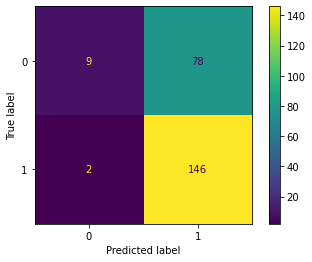

In [157]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import ConfusionMatrixDisplay

nn = MLPClassifier(alpha=1, max_iter=1000)

modeling_pipeline = Pipeline([
    ('data_processing', processing_pipeline),
    ('ml', nn)]
)

# modeling_pipeline.fit(x_train, y_train)

param_grid = [
  {'ml__alpha': [0.0001, 0.001, 1], 
   'ml__hidden_layer_sizes': [(32,), (100,)]
  }
]

lg_results = GridSearchCV(estimator=modeling_pipeline, param_grid=param_grid, scoring='f1', refit=True, cv=5)
lg_results = lg_results.fit(X_train, y_train)

ConfusionMatrixDisplay.from_estimator(lg_results, X_test, y_test)
plt.show()


GridSearch doesn't seem to improve the model.

  # Summary


- Overall, the data doesn't give us clear results. I tried multiple models. The features that I have doesn't seem like affecting the target. 
- That could be potentially due to small data having more vulnerability to sample variation. 
- The other possibility is that the data is not relying on its feature. Maybe we are missing an essential factor in determining the SL-RAT Scores.  
- I could only extract the Sl_RAT score data since July 1, 2020. So I started working with 10518 records; I had 1170 records after cleaning. I need legacy data from the old database. 
- My company is really interested in this project. Hence, I will continue looking into this project and add more features (data from different tables) which I don't have currently.